# Group-14 : 911 Call Analysis

In [92]:
#pip install jupyter_dashboards

In [93]:
#conda install jupyter_dashboards -c conda-forge

## Install essential packages

In [94]:
#Package for sqlite3 (database)
!pip install db-sqlite3

In [95]:
#Package for folium (map visualization)
!pip install folium

## Importing the required packages

In [96]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from datetime import datetime as dm
import pandas as pd
import sqlite3
from sqlite3 import Error
import folium as fm

## Help functions 

In [97]:
#Function to connect to database file
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

#Function To create table
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
#Function To execute the sql queries      
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

#To beautify the output dataframe
def beautify_table(df,bgcolor='#fff5eb'):
    
    return df.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background', '#420929'), 
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('border', '2px solid black')
               #,('background','#fff5eb')
               ]
      }

    ]
    ).hide_index().background_gradient(cmap='Blues')

In [98]:
#Initial connection and also reset the db
conn = create_connection('911data.db',True)

### To Create and insert data for TimeOfDay table

In [103]:
def step1_create_timeofday_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: dataframe to show five of the inserted rows
    conn = create_connection('911data.db') 
    l = []
    #[*range(21, 24), *range(0, 5)]
    time_details = {range(5,12):('Morning',5,11),range(12,17):('Afternoon',12,16),range(17,21):('Evening',17,20),range(21, 24):('Night',21,4),range(0, 5):('Night',21,4)}
    with open('911.csv','r') as f:
        for i in f:
            if i.split(',')[5] != 'timeStamp':
                d = i.split(',')[5]
                for k in time_details.keys():
                    if int(d.strip().split(' ')[1].split(':')[0]) in k: 
                        details = time_details[k]
                        if details not in l:
                            l.append(details)
                        break         
    f.close()
    sort_func = lambda s: s[1]
    l = sorted(l,key = sort_func)

    with conn:
        create_query = 'CREATE TABLE IF NOT EXISTS TimeOfDay (TimeOfDayID Integer NOT NULL PRIMARY KEY, TimeOfDay text NOT NULL, StartTime integer NOT NULL, EndTime integer NOT NULL);'
        create_table(conn, create_query, drop_table_name='TimeOfDay')
        insert_query = "INSERT INTO TimeOfDay (TimeOfDay,StartTime,EndTime) VALUES (?,?,?)"
        cur_region = conn.cursor()
        cur_region.executemany(insert_query,l)
    #r = execute_sql_statement('SELECT * FROM TimeOfDay',conn)
    df = pd.read_sql_query('SELECT * FROM TimeOfDay', conn)
    df = df.head(5)
    conn.commit()
    conn.close()
    return df

In [132]:
#Function call
df = step1_create_timeofday_table('911.csv', '911data.db')
#View the top inserted rows
beautify_table(df)

TimeOfDayID,TimeOfDay,StartTime,EndTime
1,Morning,5,11
2,Afternoon,12,16
3,Evening,17,20
4,Night,21,4


### To Create TimeOfDay Dictionary

In [135]:
def step2_create_timeofday_dictionary(normalized_database_filename):
    tod_dict = {}
    conn = create_connection(normalized_database_filename)
    sql_statement = "Select * from TimeOfDay"
    df = execute_sql_statement(sql_statement,conn)
    for row in df:
        tod_dict[row[1]] = row[0];
    conn.close()
    return tod_dict

In [136]:
step2_create_timeofday_dictionary('911data.db')

{'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}

### To Create and insert data for Township table

In [146]:
def step3_create_township_table(data_filename,normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: dataframe to show five of the inserted rows
    conn = create_connection(normalized_database_filename)
    l1 = []
    with open(data_filename,'r') as f1:
        for i in f1:
            if i.split(',')[6] != 'twp':
                d = i.split(',')[6].strip()
                if d != '':
                    if (d,) not in l1:
                        l1.append((d,))  
    f1.close()
    l1.sort()
    with conn:
        create_query = 'CREATE TABLE IF NOT EXISTS Township (TownshipID Integer NOT NULL PRIMARY KEY, TownshipName text NOT NULL);'
        create_table(conn, create_query, drop_table_name='Township')
        insert_query = "INSERT INTO Township (TownshipName) VALUES (?)"
        cur_region = conn.cursor()
        cur_region.executemany(insert_query,l1)
    #r = execute_sql_statement('SELECT * FROM Township',conn)
    df = pd.read_sql_query('SELECT * FROM Township', conn)
    df = df.head(5);
    conn.commit()
    conn.close()
    return df

In [147]:
df = step3_create_township_table('911.csv', '911data.db')
beautify_table(df)

TownshipID,TownshipName
1,ABINGTON
2,AMBLER
3,BERKS COUNTY
4,BRIDGEPORT
5,BRYN ATHYN


### To Create Township dictionary

In [148]:
def step4_create_township_dictionary(normalized_database_filename):    
    twp_dict = {}
    conn = create_connection(normalized_database_filename)
    sql_statement = "Select * from Township"
    df = execute_sql_statement(sql_statement,conn)
    for row in df:
        twp_dict[row[1]] = row[0];
    conn.close()
    return twp_dict

In [149]:
step4_create_township_dictionary('911data.db')


{'ABINGTON': 1,
 'AMBLER': 2,
 'BERKS COUNTY': 3,
 'BRIDGEPORT': 4,
 'BRYN ATHYN': 5,
 'BUCKS COUNTY': 6,
 'CHELTENHAM': 7,
 'CHESTER COUNTY': 8,
 'COLLEGEVILLE': 9,
 'CONSHOHOCKEN': 10,
 'DELAWARE COUNTY': 11,
 'DOUGLASS': 12,
 'EAST GREENVILLE': 13,
 'EAST NORRITON': 14,
 'FRANCONIA': 15,
 'GREEN LANE': 16,
 'HATBORO': 17,
 'HATFIELD BORO': 18,
 'HATFIELD TOWNSHIP': 19,
 'HORSHAM': 20,
 'JENKINTOWN': 21,
 'LANSDALE': 22,
 'LEHIGH COUNTY': 23,
 'LIMERICK': 24,
 'LOWER FREDERICK': 25,
 'LOWER GWYNEDD': 26,
 'LOWER MERION': 27,
 'LOWER MORELAND': 28,
 'LOWER POTTSGROVE': 29,
 'LOWER PROVIDENCE': 30,
 'LOWER SALFORD': 31,
 'MARLBOROUGH': 32,
 'MONTGOMERY': 33,
 'NARBERTH': 34,
 'NEW HANOVER': 35,
 'NORRISTOWN': 36,
 'NORTH WALES': 37,
 'PENNSBURG': 38,
 'PERKIOMEN': 39,
 'PHILA COUNTY': 40,
 'PLYMOUTH': 41,
 'POTTSTOWN': 42,
 'RED HILL': 43,
 'ROCKLEDGE': 44,
 'ROYERSFORD': 45,
 'SALFORD': 46,
 'SCHWENKSVILLE': 47,
 'SKIPPACK': 48,
 'SOUDERTON': 49,
 'SPRINGFIELD': 50,
 'TELFORD': 51,
 '

### To Create and insert data for IncidentCategory table

In [153]:
def step5_create_IncidentCategory_table(data_filename,normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: dataframe to show five of the inserted rows
    conn = create_connection(normalized_database_filename)
    cat_list = []
    with open(data_filename,'r') as f1:
        for i in f1:
            if i.split(',')[4] != 'title':
                d = i.split(',')[4].strip()
                if d == '':
                    d = ('No_info','No_info')
                if (d.split(':')[0].strip(),) not in cat_list:
                    cat_list.append((d.split(':')[0].strip(),))
    f1.close()
    sort_func = lambda s: s[0]
    cat_list = sorted(cat_list,key = sort_func)

    with conn:
        create_query = '''
        CREATE TABLE IF NOT EXISTS IncidentCategory 
        (CategoryID Integer NOT NULL PRIMARY KEY AUTOINCREMENT, 
        Category text NOT NULL);'''
        create_table(conn, create_query, drop_table_name='IncidentCategory')
        insert_query = "INSERT INTO IncidentCategory (Category) VALUES (?)"
        cur_region = conn.cursor()
        cur_region.executemany(insert_query,cat_list)
    #r = execute_sql_statement('SELECT * FROM IncidentCategory',conn)
    df = pd.read_sql_query('SELECT * FROM IncidentCategory', conn)
    df = df.head(5);
    conn.commit()
    conn.close()
    return df

In [154]:
df = step5_create_IncidentCategory_table('911.csv', '911data.db')
beautify_table(df)

CategoryID,Category
1,EMS
2,Fire
3,Traffic


### To Create IncidentCategory dictionary

In [155]:
def step6_create_IncidentCategory_dictionary(normalized_database_filename):
    cat_dict = {}
    conn = create_connection(normalized_database_filename)
    sql_statement = "Select * from IncidentCategory"
    df = execute_sql_statement(sql_statement,conn)
    for row in df:
        cat_dict[row[1]] = row[0];
    conn.close()
    return cat_dict;

In [156]:
step6_create_IncidentCategory_dictionary('911data.db')

{'EMS': 1, 'Fire': 2, 'Traffic': 3}

### To Create and insert data for IncidentSubCategory table

In [159]:
def step7_create_IncidentSubCategory_table(data_filename,normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: dataframe to show five of the inserted rows
    conn = create_connection(normalized_database_filename)
    subcat_list = []
    cat_dict = step6_create_IncidentCategory_dictionary(normalized_database_filename)
    with open(data_filename,'r') as f1:
        for i in f1:
            cat_id = 0
            if i.split(',')[4] != 'title':
                d = i.split(',')[4].strip()
                if d == '':
                    d = (0,'No_info')
                cat_id = cat_dict[d.split(':')[0].strip()];    
                if (cat_id,d.split(':')[1].strip()) not in subcat_list:
                    subcat_list.append((cat_id,d.split(':')[1].strip()))
    f1.close()
    sort_func = lambda s: s[0]
    subcat_list = sorted(subcat_list,key = sort_func)
    with conn:
        create_query = '''
        CREATE TABLE IF NOT EXISTS IncidentSubCategory 
        (SubCategoryID Integer NOT NULL PRIMARY KEY AUTOINCREMENT, 
        CategoryID Integer NOT NULL,
        SubCategory Text NOT NULL,
        foreign key(CategoryID) references IncidentCategory(CategoryID));'''
        create_table(conn, create_query, drop_table_name='IncidentSubCategory')
        insert_query = "INSERT INTO IncidentSubCategory (CategoryID,SubCategory) VALUES (?,?)"
        cur_region = conn.cursor()
        cur_region.executemany(insert_query,subcat_list)
    #r = execute_sql_statement('SELECT * FROM IncidentSubCategory',conn)
    df = pd.read_sql_query('SELECT * FROM IncidentSubCategory', conn)
    df = df.head(5);
    #display(r)
    conn.commit()
    conn.close()

In [160]:
step7_create_IncidentSubCategory_table('911.csv', '911data.db')
beautify_table(df)

CategoryID,Category
1,EMS
2,Fire
3,Traffic


### To Create IncidentSubCategory dictionary

In [161]:
def step8_create_IncidentSubCategory_dictionary(normalized_database_filename):
    subcat_dict = {}
    conn = create_connection(normalized_database_filename)
    sql_statement = "Select * from IncidentSubCategory"
    df = execute_sql_statement(sql_statement,conn)
    for row in df:
        subcat_dict[row[2]] = row[0];
    conn.close()
    return subcat_dict

In [162]:
subcat_dict = step8_create_IncidentSubCategory_dictionary('911data.db')

### To Create and insert data for CallRecord table

In [165]:
def step9_create_Callrecord_table(data_filename,normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: dataframe to show five of the inserted rows
    conn = create_connection(normalized_database_filename)
    record_list = []
    cat_dict = step6_create_IncidentCategory_dictionary(normalized_database_filename);
    subcat_dict = step8_create_IncidentSubCategory_dictionary(normalized_database_filename)
    twp_dict = step4_create_township_dictionary(normalized_database_filename)
    tod_dict = step2_create_timeofday_dictionary(normalized_database_filename)
    with open(data_filename,'r') as f1:
        for i in f1:
            record_ele = []
            if i.split(',')[0] != 'lat':
                d = i.split(',')[0].strip()
                if d == '':
                    record_ele.append(None)
                else:
                    record_ele.append(d) #lat
            if i.split(',')[1] != 'lng':
                d = i.split(',')[1].strip()
                if d == '':
                    record_ele.append(None)
                else:
                    record_ele.append(d) #lng          
            if i.split(',')[4] != 'title':
                d = i.split(',')[4].strip()
                if d == '':
                    record_ele.append(None)
                    record_ele.append(None)
                else:
                    record_ele.append( cat_dict[d.split(':')[0].strip()] ) #Category ID
                    record_ele.append( subcat_dict[d.split(':')[1].strip()] ) #Sub Category ID
            if i.split(',')[2] != 'desc':
                d = i.split(',')[2].strip()
                if d == '':
                    d = 'No_info'
                record_ele.append( d ) #Description
            if i.split(',')[3] != 'zip':
                d = i.split(',')[3].strip()
                if d == '':
                    d = None
                record_ele.append( d ) #Zip               
            if i.split(',')[6] != 'twp':
                d = i.split(',')[6].strip()
                if d == '':
                    d = None
                else:
                    d = twp_dict[d]
                record_ele.append(d)  #Twp
            if i.split(',')[7] != 'addr':
                d = i.split(',')[7].strip()
                if d == '':
                    d = 'No_info'
                record_ele.append(d)  #Address   
            if i.split(',')[5] != 'timeStamp':
                d = i.split(',')[5]
                if d == '':
                    record_ele.append(None)
                    record_ele.append(None)
                else:
                    record_ele.append(d.strip().split(' ')[0]) #Date
                    for k in time_details.keys():
                        if int(d.strip().split(' ')[1].split(':')[0]) in k: 
                            record_ele.append(tod_dict[ time_details[k][0] ] ) #time of day
            record_list.append(tuple(record_ele))
    record_list = record_list[1:]  
    print(len(record_list))
    f1.close()

    with conn:
        create_query ="""
        CREATE TABLE IF NOT EXISTS CallRecord (
          [RecordID] integer not null Primary Key AUTOINCREMENT,
          [latitude] real null,
          [longitude] real null,
          [CategoryID] integer not null,
          [SubCategoryID] integer not null,
          [Desc] Text not null,
          [Zip] integer null,
          [TownshipID] integer null,
          [Address] Text null,
          [Date] Date null ,
          [TimeOfDayID] integer null,
          FOREIGN KEY(CategoryID) REFERENCES IncidentCategory(CategoryID),
          FOREIGN KEY(SubCategoryID) REFERENCES IncidentSubCategory(SubCategoryID),
          FOREIGN KEY(TownshipID) REFERENCES Township(TownshipID),
          FOREIGN KEY(TimeOfDayID) REFERENCES TimeOfDay(TimeOfDayID)
        );
        """
        create_table(conn, create_query, drop_table_name='CallRecord')
        insert_query = '''INSERT INTO CallRecord (latitude,longitude,CategoryID,SubCategoryID,Desc,Zip,TownshipID,Address,Date,TimeOfDayID) 
        VALUES (?,?,?,?,?,?,?,?,?,?)'''
        cur_region = conn.cursor()
        cur_region.executemany(insert_query,record_list)
    #r = execute_sql_statement('SELECT count(*) FROM CallRecord',conn)
    df = pd.read_sql_query('SELECT * FROM CallRecord', conn)
    df = df.head(5);
    conn.commit()
    conn.close()
    return df

In [166]:
df = step9_create_Callrecord_table('911.csv', '911data.db')
#To view top 5 inserted rows 
beautify_table(df)

663522


RecordID,latitude,longitude,CategoryID,SubCategoryID,Desc,Zip,TownshipID,Address,Date,TimeOfDayID
1,40.297876,-75.581294,1,1,REINDEER CT & DEAD END; NEW HANOVER; Station 332; 2015-12-10 @ 17:10:52;,19525.000000,35.000000,REINDEER CT & DEAD END,2015-12-10,3
2,40.258061,-75.264680,1,115,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP; Station 345; 2015-12-10 @ 17:29:21;,19446.000000,19.000000,BRIAR PATH & WHITEMARSH LN,2015-12-10,3
3,40.121182,-75.351975,2,82,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-Station:STA27;,19401.000000,36.000000,HAWS AVE,2015-12-10,2
4,40.116153,-75.343513,1,118,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A; 2015-12-10 @ 16:47:36;,19401.000000,36.000000,AIRY ST & SWEDE ST,2015-12-10,2
5,40.251492,-75.603350,1,137,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; Station 329; 2015-12-10 @ 16:56:52;,nan,29.000000,CHERRYWOOD CT & DEAD END,2015-12-10,2


## Townships generating 50% of the Call traffic records

In [167]:
conn = create_connection('911data.db')
sql_statement = f'select T.TownshipName'\
f',count(*) as TotalCalls from CallRecord CR inner join Township as T on CR.TownshipID = T.TownshipID and CR.TownshipID not null'\
f' group by T.TownshipID order by TotalCalls desc'
df = pd.read_sql_query(sql_statement, conn)
ts = sum(df['TotalCalls'])
df['Percentage'] = df['TotalCalls'].apply(lambda x:(x/ts)*100)
df['CummulativePercentage'] = df['TotalCalls'].cumsum().apply(lambda x:(x/ts)*100)
df1 = pd.DataFrame(df.loc[df['CummulativePercentage']<=50])

df1.style.hide_index().bar(subset=["Percentage"], color='#FFA07A')
df1.style.set_table_styles(
[{'selector': 'th',
  'props': [('background', '#420929'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': '',
  'props': [('border', '2px solid black'), ]
  }
 
]
).hide_index().background_gradient(cmap='Oranges')


TownshipName,TotalCalls,Percentage,CummulativePercentage
LOWER MERION,55490,8.366643,8.366643
ABINGTON,39947,6.023108,14.389751
NORRISTOWN,37633,5.674209,20.063960
UPPER MERION,36010,5.429497,25.493457
CHELTENHAM,30574,4.609871,30.103328
POTTSTOWN,27387,4.129343,34.232671
UPPER MORELAND,22932,3.457629,37.690300
LOWER PROVIDENCE,22476,3.388875,41.079175
PLYMOUTH,20116,3.033040,44.112215
UPPER DUBLIN,18862,2.843965,46.956180


## Pie chart of call traffic with respect to time of the day

<AxesSubplot:ylabel='TotalCalls'>

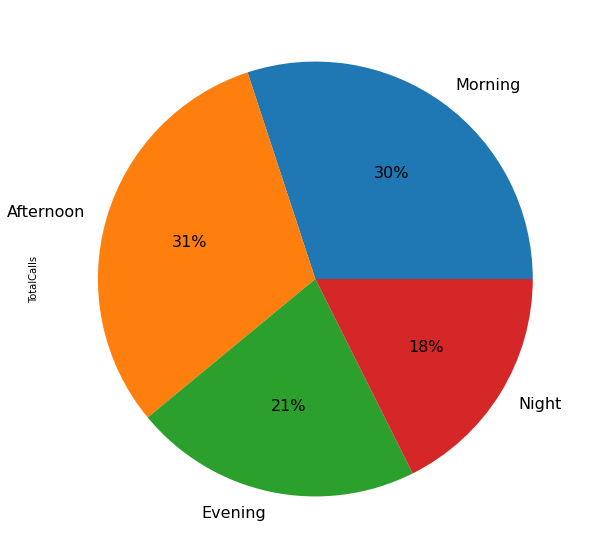

In [168]:
conn = create_connection('911data.db')
sql_statement = f'select T.TimeOfDay'\
f',count(*) as TotalCalls from CallRecord CR inner join TimeOfDay as T on CR.TimeOfDayID = T.TimeOfDayID and CR.TimeOfDayID not null'\
f' group by T.TimeOfDayID '
df = pd.read_sql_query(sql_statement, conn)

df.set_index('TimeOfDay', inplace=True)
df.plot.pie(y='TotalCalls', legend=False,autopct = '%.0f%%',figsize = (10,10),textprops={'fontsize': 16})


## Year wise trends for different incident categories

Category
EMS        AxesSubplot(0.125,0.125;0.775x0.755)
Fire       AxesSubplot(0.125,0.125;0.775x0.755)
Traffic    AxesSubplot(0.125,0.125;0.775x0.755)
Name: TotalCalls, dtype: object

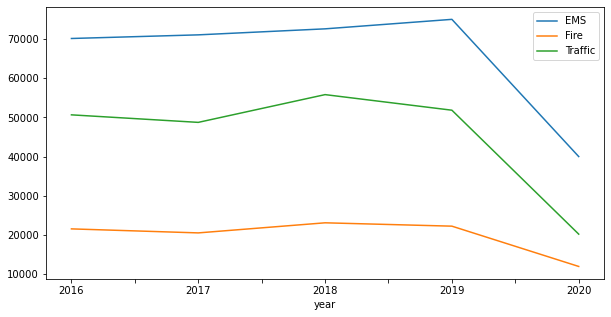

In [184]:
conn = create_connection('911data.db')
sql_statement = f'select strftime("%Y",CR.Date) as year'\
f',count(*) as TotalCalls,Category from CallRecord CR inner join IncidentCategory as IC on CR.CategoryID = IC.CategoryID and CR.CategoryID not null'\
f' group by year,CR.categoryID '
df = pd.read_sql_query(sql_statement, conn)
df = pd.DataFrame(df.loc[df['year']!='2015'])
df.set_index('year', inplace=True)
df.groupby('Category')['TotalCalls'].plot(legend=True,figsize = (10,5))




## Year wise Total calls

<AxesSubplot:xlabel='year'>

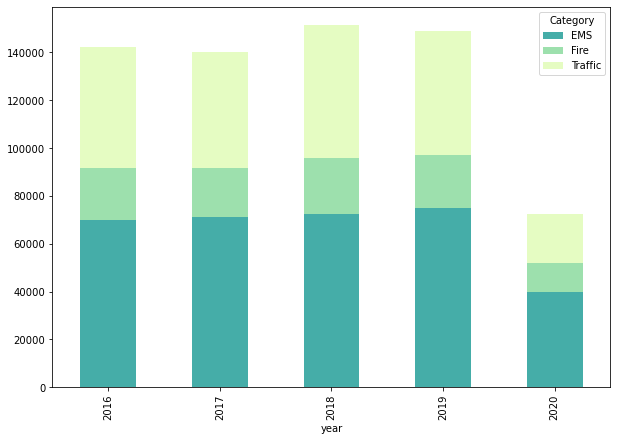

In [185]:
conn = create_connection('911data.db')
sql_statement = f'select strftime("%Y",CR.Date) as year'\
f',count(*) as TotalCalls,Category from CallRecord CR inner join IncidentCategory as IC on CR.CategoryID = IC.CategoryID and CR.CategoryID not null'\
f' group by year,CR.categoryID '
df = pd.read_sql_query(sql_statement, conn)
df = pd.DataFrame(df.loc[df['year']!='2015'])
pivot_df = df.pivot(index='year', columns='Category', values='TotalCalls')
colors = ["#45ADA8", "#9DE0AD","#E5FCC2"]
pivot_df.loc[:,['EMS','Fire', 'Traffic']].plot.bar(stacked=True, color=colors, figsize=(10,7))

### Generating data frame for Map visualization

In [202]:
conn = create_connection('911data.db')
s = """ select cr.latitude,cr.longitude,c.Category,sc.SubCategory,cr.Desc,cr.Zip,TownshipName,Address,Date,TimeOfDay from CallRecord as cr 
inner join IncidentCategory as c on cr.CategoryID = c.CategoryID 
inner join IncidentSubCategory as sc on cr.SubCategoryID = sc.SubcategoryID 
inner join TimeOfDay T on cr.TimeOfDayId = T.TimeOfDayId
inner join Township tw on cr.TownshipID = tw.TownshipID
LIMIT 3000
"""
df = pd.read_sql_query(s, conn)
beautify_table(df.head())

latitude,longitude,Category,SubCategory,Desc,Zip,TownshipName,Address,Date,TimeOfDay
40.297876,-75.581294,EMS,BACK PAINS/INJURY,REINDEER CT & DEAD END; NEW HANOVER; Station 332; 2015-12-10 @ 17:10:52;,19525.000000,NEW HANOVER,REINDEER CT & DEAD END,2015-12-10,Evening
40.258061,-75.264680,EMS,DIABETIC EMERGENCY,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP; Station 345; 2015-12-10 @ 17:29:21;,19446.000000,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,2015-12-10,Evening
40.121182,-75.351975,Fire,GAS-ODOR/LEAK,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-Station:STA27;,19401.000000,NORRISTOWN,HAWS AVE,2015-12-10,Afternoon
40.116153,-75.343513,EMS,CARDIAC EMERGENCY,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A; 2015-12-10 @ 16:47:36;,19401.000000,NORRISTOWN,AIRY ST & SWEDE ST,2015-12-10,Afternoon
40.251492,-75.603350,EMS,DIZZINESS,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; Station 329; 2015-12-10 @ 16:56:52;,nan,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,2015-12-10,Afternoon


### Background and icon color dictionaries

In [204]:
dic_col={"Monday":"orange","Tuesday":"green","Wednesday":"blue","Thursday":"purple","Friday":"pink","Saturday":"violet","Sunday":"red"}
dic_days={"0":"orange","1":"green","2":"blue","3":"purple","4":"pink","5":"darkpurple","6":"red"}
dic_col_tod = {"Morning":"#a3cce3","Afternoon":"#f16813","Evening":"#fdc794","Night":"#08306b"}

## Call records visualization on basis of location on Map

In [212]:
plotWeb =fm.Map(location=[df["latitude"].mean(),df["longitude"].mean()],zoom_start=12,tiles='OpenStreetMap')
groups =fm.FeatureGroup(name="911 Calls Map")

popup = fm.Popup(iframe)
for i,x in df.iterrows():
    html = f'<body style="background-color:{dic_col_tod[x["TimeOfDay"]]};"><p style="color:white;"><b>{x["TownshipName"]}</b></p>\
    <p style="color:white;">Category: {x["Category"]}</p>\
    <p style="color:white;">Sub Category: {x["SubCategory"]}</p></body>'

    iframe = fm.IFrame(html,
                           width=200,
                           height=120)

    popup = fm.Popup(iframe)
    #groups.add_child(fm.Marker(location=[x["latitude"], x["longitude"]],popup=str(x["Category"])+': '+str(x["SubCategory"]),icon=fm.Icon(color=dic_days[str(pd.Timestamp(x["Date"]).dayofweek)])))
    groups.add_child(fm.Marker(location=[x["latitude"], x["longitude"]],popup=popup,icon=fm.Icon(color=dic_days[str(pd.Timestamp(x["Date"]).dayofweek)])))
plotWeb.add_child(groups)

plotWeb.save('Tr_300_.html')